# Check and refine Dtag click detection

This notebook checks and refines the temporal location of click detections on Dtag recordings. The inputs were first generated using NMF (`click_detection_batch_export.ipynb`) and then had gone through a first level of cleaning (from `dtag/dtag_detection_uncleaned` to `dtag/dtag_detection_cleaned`).

- input: detections at a reduced temporal resolution due to their source (NMF on FFT spectrum)
- output: refined detections at the same resolution as the Dtag wav files in `npz` format

Content of this notebook combines 2 previous notebook:
- `20201221_dtag-click-detection-check-refine.ipynb`
- `20210407_produce-refined-dtag-click-locs-pks-npz.ipynb`

These `npz` files are later loaded into the click detection GUI for a final clean up to produce outputs in `dtag_reclean_202104/points_cleaned`.

Note here I preserve the folder names and structures used in the old repo to make later reference/comparison easier.

In [1]:
from pathlib import Path
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import soundfile as sf
from scipy import signal
# from scipy.io import wavfile

## Set up paths

In [2]:
analysis_path = Path("../data_processed/")
raw_path = Path("../data_raw/")

In [3]:
# input paths
detection_path = analysis_path / 'dtag/dtag_detection_cleaned'
filtered_wav_path = analysis_path / 'dtag/dtag_split_wav_filtered/'

In [4]:
# output path
refined_detection_path = analysis_path / 'dtag/dtag_detection_cleaned_refined_npz'

if not refined_detection_path.exists():
    refined_detection_path.mkdir()

## Load trial info

In [5]:
df_main = pd.read_csv(
    analysis_path / "all_info_csv/main_info_append_10.csv",
    index_col=0
)

## Check NMF detection on a specific trial

In [6]:
def get_smpl_num(t_str, smpl_freq):
    tt = datetime.datetime.strptime(t_str, '%M:%S.%f')
    return int(smpl_freq * (tt.minute * 60 + tt.second + tt.microsecond * 1e-6))

In [7]:
trial_idx = 0

In [8]:
ts = df_main.loc[trial_idx]
filtered_wav_filename = (
    f"t{trial_idx:03d}"
    f"_{ts['DATE']}"
    f"_s{ts['SESSION']}"
    f"_t{ts['TRIAL']:02d}_dtag_filtered.wav"
)

In [9]:
sig, fs_dtag = sf.read(filtered_wav_path / filtered_wav_filename)
sig_t = np.arange(sig.size) / fs_dtag

# Get spectrogram
spec_f, spec_t, Sxx = signal.spectrogram(sig, fs_dtag, nperseg=256)
Pxx_log = 10*np.log10(Sxx)

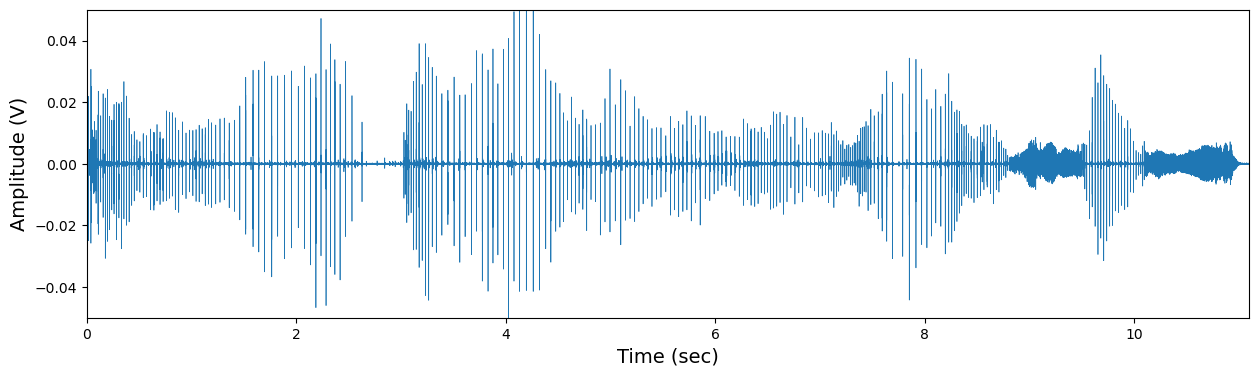

In [10]:
plt.figure(figsize=(15,4))
plt.plot(sig_t, sig, lw=0.5)
plt.xlim(0,sig_t.max())
plt.ylim(-0.05,0.05)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('Amplitude (V)', fontsize=14)
plt.show()

In [ ]:
plt.figure(figsize=(16,4))
plt.pcolormesh(spec_t, spec_f, Pxx_log, vmin=-160, vmax=-100)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

In [12]:
# Load click detection
detection_fname = detection_path / f't{trial_idx:d}_peaks_cleaned.npy'
print('load detection: ' + str(detection_fname))
clicks = np.load(detection_fname, allow_pickle=True)

load detection: ../data_processed/dtag/dtag_detection_cleaned/t0_peaks_cleaned.npy


In [13]:
nperseg=256

In [14]:
sig_t.max()

11.099998263888889

In [15]:
spec_t.shape

(28542,)

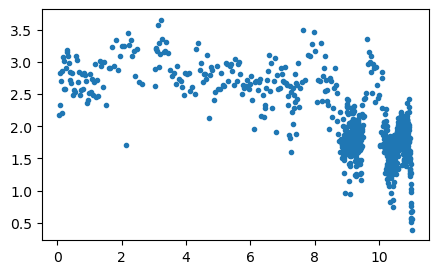

In [16]:
plt.figure(figsize=(5, 3))
plt.plot(spec_t[clicks[0,:].astype(int)], clicks[1,:], '.')

In [ ]:
plt.figure(figsize=(16,4))
plt.pcolormesh(spec_t, spec_f, Pxx_log, vmin=-160, vmax=-100)
plt.plot(spec_t[clicks[0,:].astype(int)], 200e3*np.ones(clicks.shape[1]), 'r.', markersize=6)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

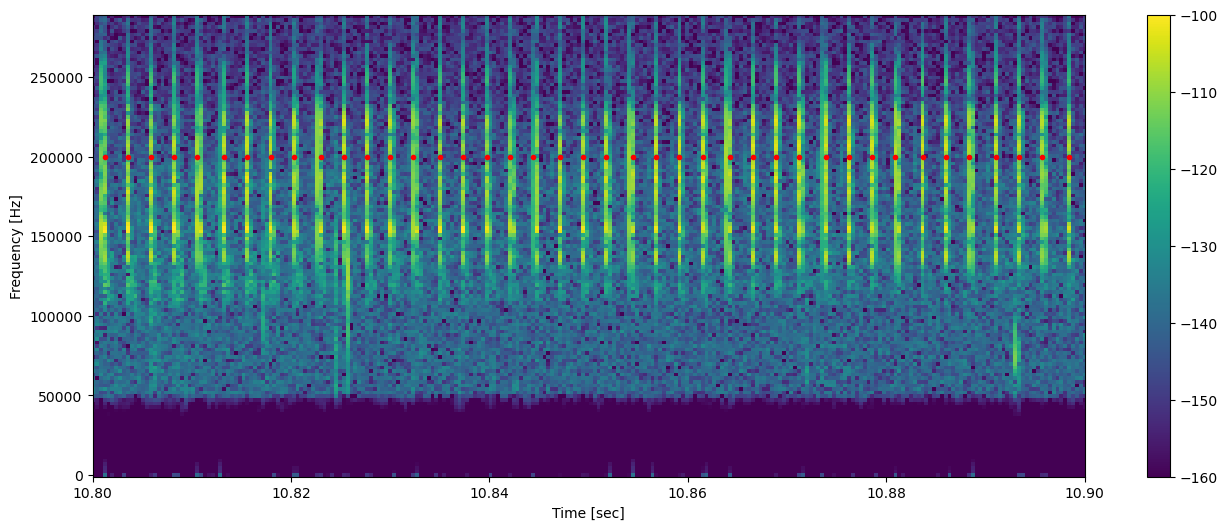

In [18]:
xlim = np.array([10.5, 10.6])+0.3
# xlim = np.array([3, 3.6])

plt.figure(figsize=(16,6))
plt.pcolormesh(spec_t, spec_f, Pxx_log, vmin=-160, vmax=-100)
plt.plot(spec_t[clicks[0,:].astype(int)], 200e3*np.ones(clicks.shape[1]), 'r.', markersize=6)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.xlim(xlim)
plt.colorbar()
plt.show()

In [19]:
256/fs_dtag

0.00044444444444444447

## Refine detection time

The above check shows that the detections are right on top of the clicks in the spectrogram. Now we need to extract the actual peak in the time series.

Let's use a section of the buzz phase to do this to make sure that the temporal resolution is adequate.

### Check rough position of the click detections wrt signal peaks

In [20]:
xlim = np.array([10.5, 10.6])+0.3
xlim

array([10.8, 10.9])

In [21]:
spec_idx_start, spec_idx_end = np.abs(np.expand_dims(xlim, axis=1) 
                            - np.expand_dims(spec_t, axis=0)).argmin(axis=1)
spec_idx_start, spec_idx_end

(27771, 28028)

In [22]:
sig_idx_start, sig_idx_end = np.abs(np.expand_dims(xlim, axis=1) 
                                    - np.expand_dims(sig_t, axis=0)).argmin(axis=1)
sig_idx_start, sig_idx_end

(6220800, 6278400)

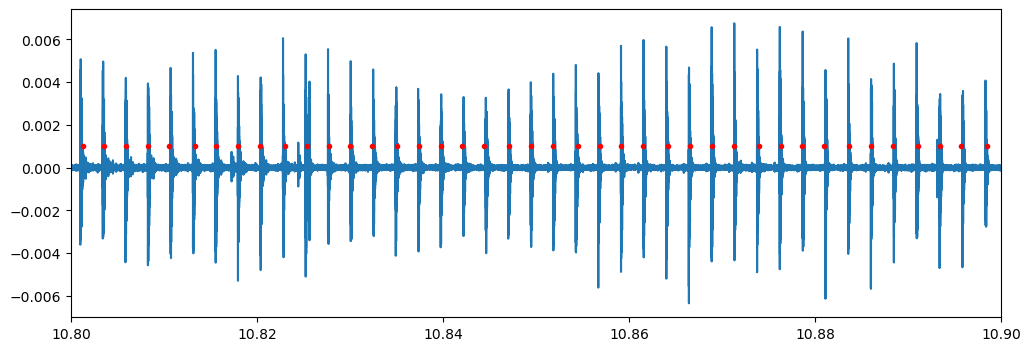

In [23]:
plt.figure(figsize=(12, 4))
plt.plot(sig_t[sig_idx_start:sig_idx_end], sig[sig_idx_start:sig_idx_end])
plt.plot(spec_t[clicks[0,:].astype(int)], 0.001*np.ones(clicks.shape[1]), 'r.', markersize=6)
plt.xlim(xlim)
plt.show()

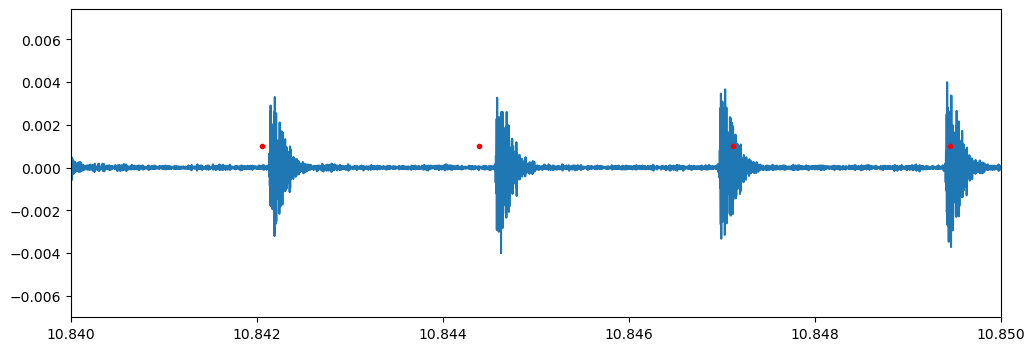

In [24]:
plt.figure(figsize=(12, 4))
plt.plot(sig_t[sig_idx_start:sig_idx_end], sig[sig_idx_start:sig_idx_end])
plt.plot(spec_t[clicks[0,:].astype(int)], 0.001*np.ones(clicks.shape[1]), 'r.', markersize=6)
plt.xlim(10.84, 10.85)
plt.show()

### Center nperseg window at the detection points

In [25]:
win_idx = np.arange(nperseg) - nperseg/2  # base indices for getting the window around detection points

In [26]:
clk_seg = []
curr_win_idx_all = []
for clk_loc_spec in clicks[0, :5]:
    clk_loc_dtag = np.round(spec_t[clk_loc_spec.astype(int)] * fs_dtag)
    curr_win_idx = (clk_loc_dtag + win_idx).astype(int)
    
    curr_win_idx_all.append(curr_win_idx)
    clk_seg.append(sig[curr_win_idx])

Sanity check: are we getting the right segment? --> Yes!

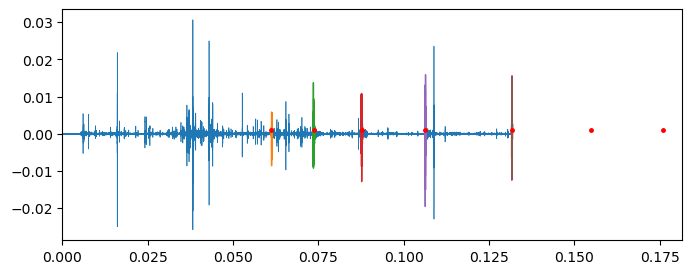

In [27]:
plt.figure(figsize=(8, 3))
plt.plot(sig_t[:np.array(curr_win_idx_all).max()], sig[:np.array(curr_win_idx_all).max()], lw=0.5)
for curr_win_idx in curr_win_idx_all:
    plt.plot(sig_t[curr_win_idx], sig[curr_win_idx], lw=1)
plt.plot(spec_t[clicks[0,:].astype(int)], 0.001*np.ones(clicks.shape[1]), 'r.', markersize=5)
plt.xlim(0, spec_t[clicks[0, :5].astype(int)].max()+0.05)
plt.show()

### Detect peak within the segment for refining the click location

In [28]:
win_idx = np.arange(nperseg) - nperseg/2  # base indices for getting the window around detection points

In [29]:
clk_loc_refine = []
for clk_loc_spec in clicks[0, :5]:
    clk_loc_dtag = np.round(spec_t[clk_loc_spec.astype(int)] * fs_dtag)
    curr_win_idx = (clk_loc_dtag + win_idx).astype(int)
    sig_seg_pk_loc = (np.abs(signal.hilbert(sig[curr_win_idx])).argmax() 
                      + curr_win_idx[0])  # peak loc corrected for window location
    
    clk_loc_refine.append(sig_seg_pk_loc)

In [30]:
sig_env = np.abs(signal.hilbert(sig))

Sanity check: are we getting the peak location correctly? --> Yes!

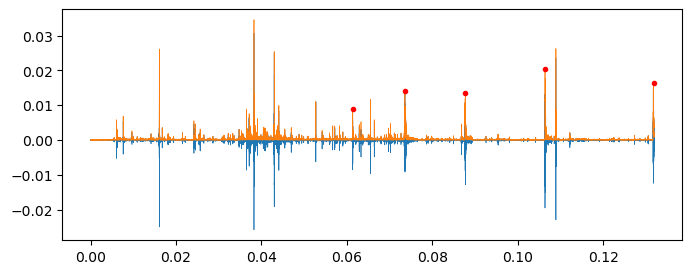

In [31]:
# %matplotlib notebook
plt.figure(figsize=(8, 3))
plt.plot(sig_t[:np.array(curr_win_idx_all).max()], 
         sig[:np.array(curr_win_idx_all).max()], lw=0.5)
plt.plot(sig_t[:np.array(curr_win_idx_all).max()], 
         np.abs(signal.hilbert(sig))[:np.array(curr_win_idx_all).max()], lw=0.5)
for clk_loc in clk_loc_refine:
    plt.plot(sig_t[clk_loc], sig_env[clk_loc], 'r.')
plt.show()

### click location refinement for all clicks, with detailed check in the buzz phase

In [32]:
win_idx = np.arange(nperseg) - nperseg/2  # base indices for getting the window around detection points

In [33]:
clk_loc_refine = []
for clk_loc_spec in clicks[0, :]:
    clk_loc_dtag = np.round(spec_t[clk_loc_spec.astype(int)] * fs_dtag)
    curr_win_idx = (clk_loc_dtag + win_idx).astype(int)
    sig_seg_pk_loc = (np.abs(signal.hilbert(sig[curr_win_idx])).argmax() 
                      + curr_win_idx[0])  # peak loc corrected for window location
    
    clk_loc_refine.append(sig_seg_pk_loc)

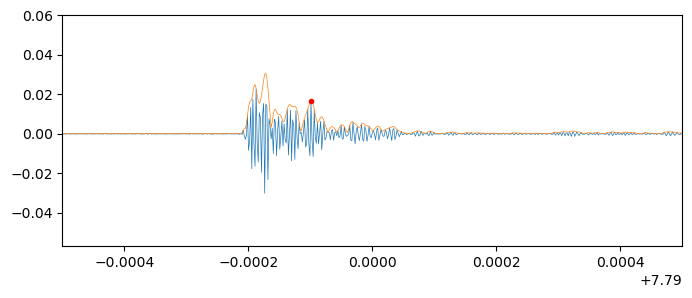

In [34]:
# %matplotlib notebook
plt.figure(figsize=(8, 3))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
for clk_loc in clk_loc_refine:
    plt.plot(sig_t[clk_loc], sig_env[clk_loc], 'r.')
plt.xlim(7.79-0.0005, 7.79+0.0005)
plt.show()

We can see that for most of the clicks the detection falls right on top of the peak of the time series, but for some the true peak precedes the refined peak. Let's try to expand the detection window a little wider.

In [35]:
win_idx = np.arange(nperseg*2) - nperseg  # base indices for getting the window around detection points

In [36]:
clk_loc_refine = []
for clk_loc_spec in clicks[0, :]:
    clk_loc_dtag = np.round(spec_t[clk_loc_spec.astype(int)] * fs_dtag)
    curr_win_idx = (clk_loc_dtag + win_idx).astype(int)
    sig_seg_pk_loc = (np.abs(signal.hilbert(sig[curr_win_idx])).argmax() 
                      + curr_win_idx[0])  # peak loc corrected for window location
    
    clk_loc_refine.append(sig_seg_pk_loc)

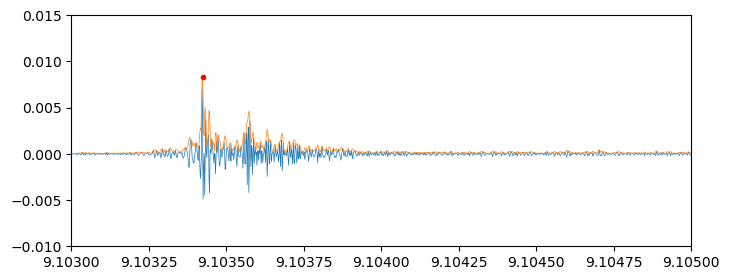

In [37]:
# %matplotlib notebook
plt.figure(figsize=(8, 3))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
for clk_loc in clk_loc_refine:
    plt.plot(sig_t[clk_loc], sig_env[clk_loc], 'r.')
plt.xlim(9.103, 9.105)
plt.ylim(-0.01, 0.015)
plt.show()

In the above case, the detected peak is actually a noise peak and the true peak is the one on the right.

It seems better to stick with the original window size (nperseg=256) and tolerate the small (~100 $\mu$s) deviation, then risking getting a noise peak. Though obviously these are not going to impact the results much.

## Check another trial just to be sure

In [38]:
trial_idx = 100
ts = df_main.loc[trial_idx]

In [39]:
filtered_wav_filename = (
    f"t{trial_idx:03d}"
    f"_{ts['DATE']}"
    f"_s{ts['SESSION']}"
    f"_t{ts['TRIAL']:02d}_dtag_filtered.wav"
)

In [40]:
sig, _ = sf.read(filtered_wav_path / filtered_wav_filename)
sig_t = np.arange(sig.size) / fs_dtag

# Get spectrogram
spec_f, spec_t, Sxx = signal.spectrogram(sig, fs_dtag, nperseg=256)
Pxx_log = 10*np.log10(Sxx)

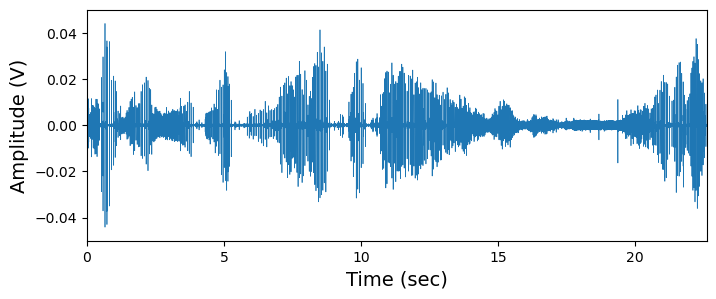

In [41]:
# %matplotlib inline
plt.figure(figsize=(8,3))
plt.plot(sig_t, sig, lw=0.5)
plt.xlim(0,sig_t.max())
plt.ylim(-0.05,0.05)
plt.xlabel('Time (sec)', fontsize=14)
plt.ylabel('Amplitude (V)', fontsize=14)
plt.show()

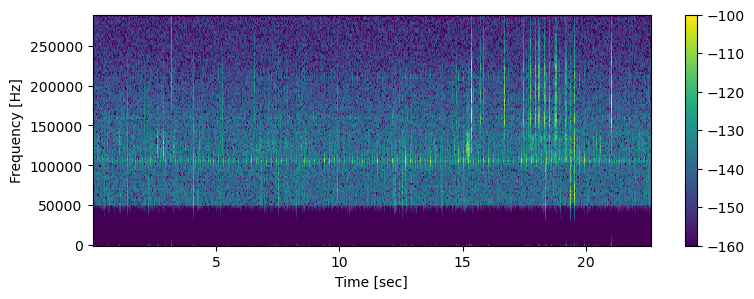

In [42]:
# %matplotlib inline
plt.figure(figsize=(9,3))
plt.pcolormesh(spec_t, spec_f, Pxx_log, vmin=-160, vmax=-100)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.show()

In [43]:
# Load click detection
detection_fname = detection_path / f't{trial_idx:d}_peaks_cleaned.npy'
print('load detection: ' + str(detection_fname))
clicks = np.load(detection_fname, allow_pickle=True)

load detection: ../data_processed/dtag/dtag_detection_cleaned/t100_peaks_cleaned.npy


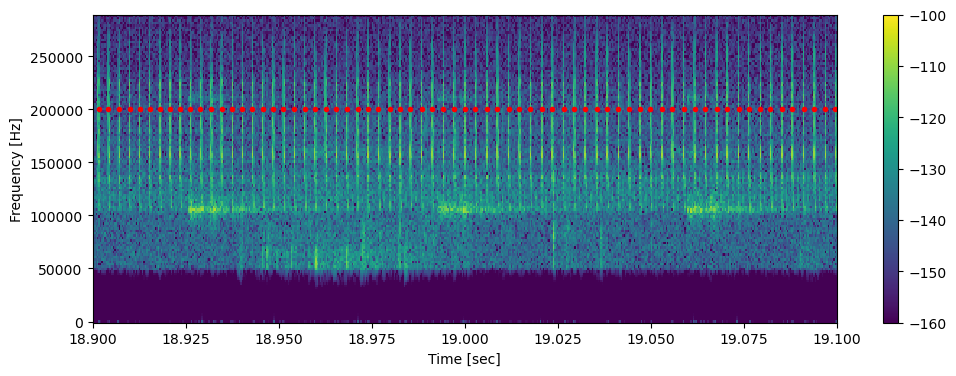

In [44]:
# %matplotlib notebook
# %matplotlib notebook
plt.figure(figsize=(12, 4))
plt.pcolormesh(spec_t, spec_f, Pxx_log, vmin=-160, vmax=-100)
plt.plot(spec_t[clicks[0,:].astype(int)], 200e3*np.ones(clicks.shape[1]), 'r.', markersize=6)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
plt.xlim(18.900, 19.100)
plt.show()

In [45]:
win_idx = np.arange(nperseg) - nperseg/2  # base indices for getting the window around detection points

In [46]:
sig_env = np.abs(signal.hilbert(sig))

In [47]:
clk_loc_refine = []
for clk_loc_spec in clicks[0, :]:
    clk_loc_dtag = np.round(spec_t[clk_loc_spec.astype(int)] * fs_dtag)
    curr_win_idx = (clk_loc_dtag + win_idx).astype(int)
    sig_seg_pk_loc = (np.abs(signal.hilbert(sig[curr_win_idx])).argmax() 
                      + curr_win_idx[0])  # peak loc corrected for window location
    
    clk_loc_refine.append(sig_seg_pk_loc)

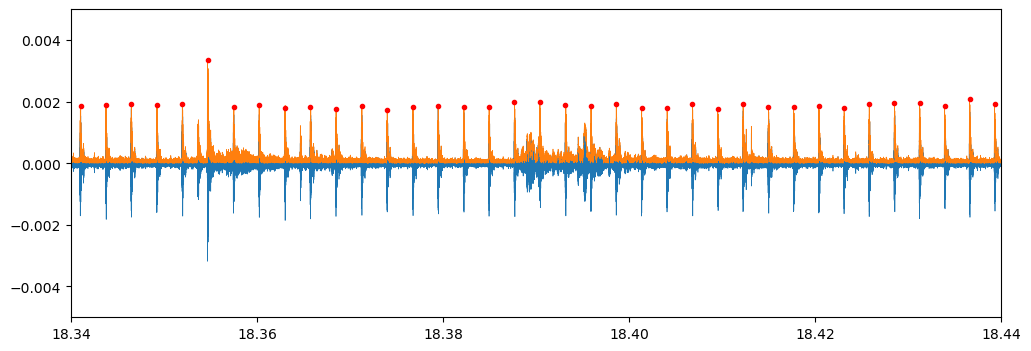

In [48]:
# %matplotlib notebook
# %matplotlib notebook
plt.figure(figsize=(12, 4))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
for clk_loc in clk_loc_refine:
    plt.plot(sig_t[clk_loc], sig_env[clk_loc], 'r.')
plt.xlim(18.34, 18.44)
plt.ylim(-0.005, 0.005)
plt.show()

In the above case where there is a lot of contamination in the time series, this click location refinement actually works really well (as in not detecting the noise peaks), probably by luck.

## Refine detected clicks for all trials

In [49]:
def get_sig(trial_idx):
    
    ts = df_main.loc[trial_idx]

    filtered_wav_filename = (
        f"t{trial_idx:03d}"
        f"_{ts['DATE']}"
        f"_s{ts['SESSION']}"
        f"_t{ts['TRIAL']:02d}_dtag_filtered.wav"
    )
    sig, _ = sf.read(filtered_wav_path / filtered_wav_filename)    
    sig_env = np.abs(signal.hilbert(sig))

    # get signal timestamp
    sig_t = np.arange(sig.size) / fs_dtag
    
    # get spectrogram timestamps
    _, spec_t, _ = signal.spectrogram(sig, fs_dtag, nperseg=256)
    
    return sig, sig_env, sig_t, spec_t

In [50]:
def load_click_detection(trial_idx):
    detection_fname = detection_path / f't{trial_idx:d}_peaks_cleaned.npy'
    print('load detection: ' + str(detection_fname))
    clicks = np.load(detection_fname, allow_pickle=True)
    return clicks

In [51]:
def refine_detection(clicks, spec_t, nperseg=256):
    # base indices for getting the window around detection points
    win_idx = np.arange(nperseg) - nperseg/2
    
    # loop through all clicks
    clk_loc_refine = []
    for clk_loc_spec in clicks[0, :]:
        clk_loc_dtag = np.round(spec_t[clk_loc_spec.astype(int)] * fs_dtag)
        curr_win_idx = (clk_loc_dtag + win_idx).astype(int)
        sig_seg_pk_loc = (np.abs(signal.hilbert(sig[curr_win_idx])).argmax() 
                          + curr_win_idx[0])  # peak loc corrected for window location
        clk_loc_refine.append(sig_seg_pk_loc)
    return np.array(clk_loc_refine)

### Sanity check that the above functions actually work --> Yes!

In [52]:
trial_idx = 10
sig, sig_env, sig_t, spec_t = get_sig(trial_idx)
clicks = load_click_detection(trial_idx)
click_loc_refine = refine_detection(clicks, spec_t)

load detection: ../data_processed/dtag/dtag_detection_cleaned/t10_peaks_cleaned.npy


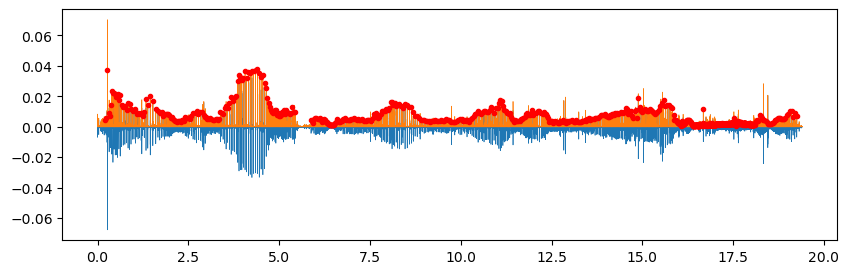

In [53]:
# %matplotlib notebook
# %matplotlib notebook
plt.figure(figsize=(10, 3))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
plt.plot(sig_t[click_loc_refine], sig_env[click_loc_refine], 'r.')
plt.show()

### Loop through all trials and save results

In [54]:
for trial_idx in df_main.index:
    print('----------------------------------------------')
    print(f'Processing trial {trial_idx}')
    
    # load signal and refine detection
    sig, sig_env, sig_t, spec_t = get_sig(trial_idx)
    clicks = load_click_detection(trial_idx)
    locs_refined = refine_detection(clicks, spec_t)  # refined click location
    pks = sig_env[locs_refined]  # click peak value
    
    # save refined detection results
    output_fname = f't{trial_idx:03d}_peaks_cleaned_refined.npz'
    print('save detection: ' + str(output_fname))
    np.savez(refined_detection_path / output_fname, location=[locs_refined], peak=[pks])    

----------------------------------------------
Processing trial 0
load detection: ../data_processed/dtag/dtag_detection_cleaned/t0_peaks_cleaned.npy
save detection: t000_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 1
load detection: ../data_processed/dtag/dtag_detection_cleaned/t1_peaks_cleaned.npy
save detection: t001_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 2
load detection: ../data_processed/dtag/dtag_detection_cleaned/t2_peaks_cleaned.npy
save detection: t002_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 3
load detection: ../data_processed/dtag/dtag_detection_cleaned/t3_peaks_cleaned.npy
save detection: t003_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 4
load detection: ../data_processed/dtag/dtag_detection_cleaned/t4_peaks_cleaned.npy
save detection: t004_peaks_cleaned_refined.npz
--------------------

load detection: ../data_processed/dtag/dtag_detection_cleaned/t42_peaks_cleaned.npy
save detection: t042_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 43
load detection: ../data_processed/dtag/dtag_detection_cleaned/t43_peaks_cleaned.npy
save detection: t043_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 44
load detection: ../data_processed/dtag/dtag_detection_cleaned/t44_peaks_cleaned.npy
save detection: t044_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 45
load detection: ../data_processed/dtag/dtag_detection_cleaned/t45_peaks_cleaned.npy
save detection: t045_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 46
load detection: ../data_processed/dtag/dtag_detection_cleaned/t46_peaks_cleaned.npy
save detection: t046_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 47
load detec

load detection: ../data_processed/dtag/dtag_detection_cleaned/t84_peaks_cleaned.npy
save detection: t084_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 85
load detection: ../data_processed/dtag/dtag_detection_cleaned/t85_peaks_cleaned.npy
save detection: t085_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 86
load detection: ../data_processed/dtag/dtag_detection_cleaned/t86_peaks_cleaned.npy
save detection: t086_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 87
load detection: ../data_processed/dtag/dtag_detection_cleaned/t87_peaks_cleaned.npy
save detection: t087_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 88
load detection: ../data_processed/dtag/dtag_detection_cleaned/t88_peaks_cleaned.npy
save detection: t088_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 89
load detec

load detection: ../data_processed/dtag/dtag_detection_cleaned/t126_peaks_cleaned.npy
save detection: t126_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 127
load detection: ../data_processed/dtag/dtag_detection_cleaned/t127_peaks_cleaned.npy
save detection: t127_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 128
load detection: ../data_processed/dtag/dtag_detection_cleaned/t128_peaks_cleaned.npy
save detection: t128_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 129
load detection: ../data_processed/dtag/dtag_detection_cleaned/t129_peaks_cleaned.npy
save detection: t129_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 130
load detection: ../data_processed/dtag/dtag_detection_cleaned/t130_peaks_cleaned.npy
save detection: t130_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 131


load detection: ../data_processed/dtag/dtag_detection_cleaned/t167_peaks_cleaned.npy
save detection: t167_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 168
load detection: ../data_processed/dtag/dtag_detection_cleaned/t168_peaks_cleaned.npy
save detection: t168_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 169
load detection: ../data_processed/dtag/dtag_detection_cleaned/t169_peaks_cleaned.npy
save detection: t169_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 170
load detection: ../data_processed/dtag/dtag_detection_cleaned/t170_peaks_cleaned.npy
save detection: t170_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 171
load detection: ../data_processed/dtag/dtag_detection_cleaned/t171_peaks_cleaned.npy
save detection: t171_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 172


load detection: ../data_processed/dtag/dtag_detection_cleaned/t208_peaks_cleaned.npy
save detection: t208_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 209
load detection: ../data_processed/dtag/dtag_detection_cleaned/t209_peaks_cleaned.npy
save detection: t209_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 210
load detection: ../data_processed/dtag/dtag_detection_cleaned/t210_peaks_cleaned.npy
save detection: t210_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 211
load detection: ../data_processed/dtag/dtag_detection_cleaned/t211_peaks_cleaned.npy
save detection: t211_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 212
load detection: ../data_processed/dtag/dtag_detection_cleaned/t212_peaks_cleaned.npy
save detection: t212_peaks_cleaned_refined.npz
----------------------------------------------
Processing trial 213


These `npz` files are later loaded into the click detection GUI for a final clean up to produce outputs in `dtag_reclean_202104/points_cleaned`.

## Sanity check for a couple trials

### Trial 0

In [55]:
trial_idx = 0
sig, sig_env, sig_t, spec_t = get_sig(trial_idx)
clicks = np.load(refined_detection_path / f't{trial_idx:03d}_peaks_cleaned_refined.npz')

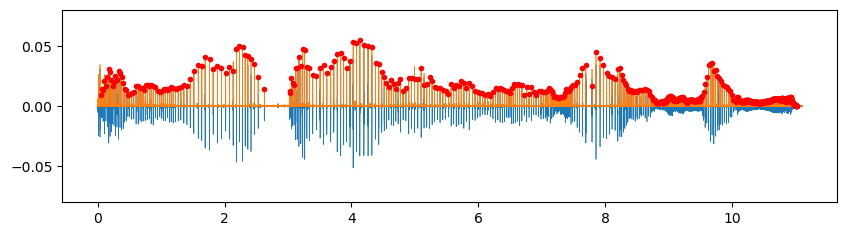

In [56]:
plt.figure(figsize=(10, 2.5))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
plt.plot(clicks["location"] / fs_dtag, clicks["peak"], 'r.')
plt.ylim(-0.08, 0.08)
plt.show()

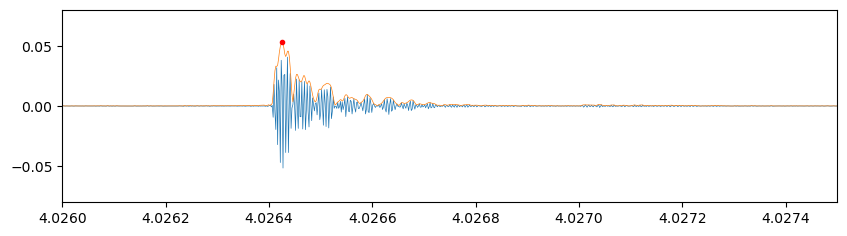

In [57]:
plt.figure(figsize=(10, 2.5))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
plt.plot(clicks["location"] / fs_dtag, clicks["peak"], 'r.')
plt.ylim(-0.08, 0.08)
plt.xlim(4.026, 4.0275)
plt.show()

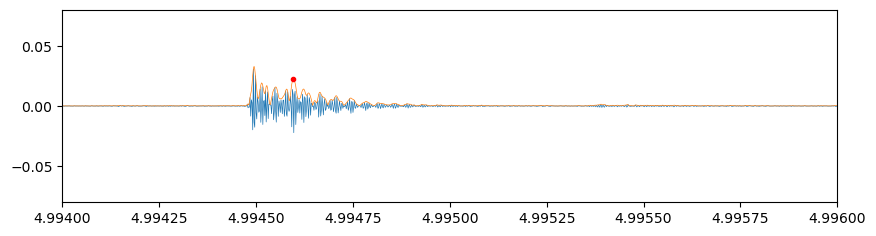

In [58]:
plt.figure(figsize=(10, 2.5))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
plt.plot(clicks["location"] / fs_dtag, clicks["peak"], 'r.')
plt.ylim(-0.08, 0.08)
plt.xlim(4.994, 4.996)
plt.show()

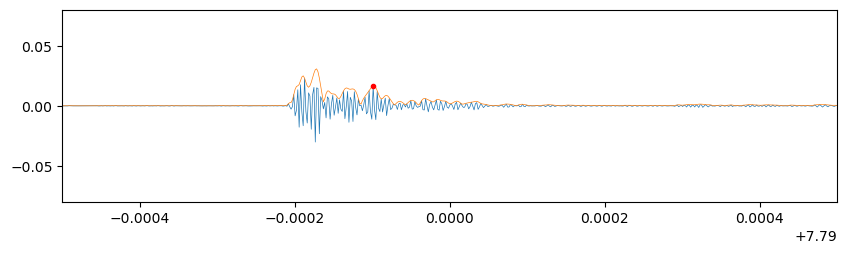

In [59]:
plt.figure(figsize=(10, 2.5))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
plt.plot(clicks["location"] / fs_dtag, clicks["peak"], 'r.')
plt.ylim(-0.08, 0.08)
plt.xlim(7.7895, 7.7905)
plt.show()

### Trial 10

In [60]:
trial_idx = 10
sig, sig_env, sig_t, spec_t = get_sig(trial_idx)
clicks = np.load(refined_detection_path / f't{trial_idx:03d}_peaks_cleaned_refined.npz')

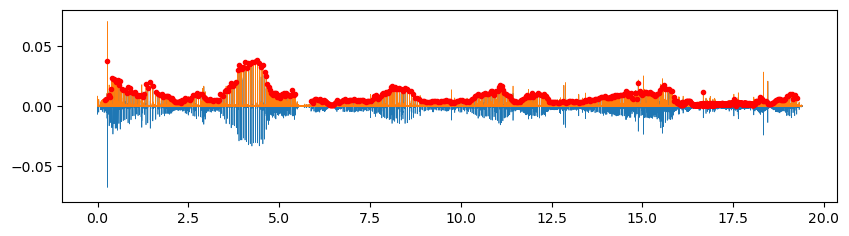

In [61]:
plt.figure(figsize=(10, 2.5))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
plt.plot(clicks["location"] / fs_dtag, clicks["peak"], 'r.')
plt.ylim(-0.08, 0.08)
plt.show()

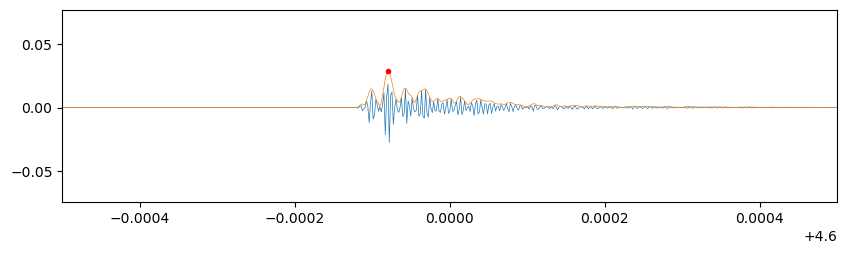

In [62]:
plt.figure(figsize=(10, 2.5))
plt.plot(sig_t, sig, lw=0.5)
plt.plot(sig_t, sig_env, lw=0.5)
plt.plot(clicks["location"] / fs_dtag, clicks["peak"], 'r.')
plt.xlim(4.5995, 4.6005)
plt.show()